# Data Challenge

## EDA

In [14]:
# Importing neccesary packages and files.
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



In [15]:
train_x = pd.read_csv('train_x_region.csv')
train_y = pd.read_csv('train_y.csv')
test_features = pd.read_csv('test_x_region.csv')

In [16]:
# Let's look at the overview of the data
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Year                           242 non-null    int64  
 1   Country                        242 non-null    object 
 2   Happiness Rank                 242 non-null    int64  
 3   Happiness Score                242 non-null    float64
 4   Economy (GDP per Capita)       242 non-null    float64
 5   Family                         242 non-null    float64
 6   Health (Life Expectancy)       242 non-null    float64
 7   Freedom                        242 non-null    float64
 8   Trust (Government Corruption)  242 non-null    float64
 9   Generosity                     242 non-null    float64
 10  Population Estimate            242 non-null    int64  
 11  Region                         242 non-null    object 
dtypes: float64(7), int64(3), object(2)
memory usage: 2

In [17]:
# Looks like Country and Region are not numerical, but aside from that, there are no sign of missing data.
# Let's check
train_x.isna().sum()

Year                             0
Country                          0
Happiness Rank                   0
Happiness Score                  0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Population Estimate              0
Region                           0
dtype: int64

In [18]:
# That's great, we will now use One-hot encoding to transfrom the two String columns.

transformed_op = pd.get_dummies(train_x[['Country', 'Region']])
train_x = pd.concat([train_x, pd.DataFrame(transformed_op)], axis = 1)
train_x.drop(['Country'], axis=1, inplace=True)
train_x.drop(['Region'], axis=1, inplace=True)

train_x.describe()

,Year,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Population Estimate,...,Country_United Kingdom,Country_Uruguay,Country_Venezuela,Country_Vietnam,Region_East Asia & Pacific,Region_Europe & Central Asia,Region_Latin America & Caribbean,Region_Middle East & North Africa,Region_South Asia,Region_Sub-Saharan Africa
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,2.420000e+02,...,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,2016.954545,58.037190,5.895496,2.884285,1.172189,0.882891,0.538545,0.258015,0.188854,8.774480e+07,...,0.016529,0.012397,0.012397,0.020661,0.128099,0.334711,0.359504,0.103306,0.020661,0.053719
std,1.435328,41.147073,1.051886,2.456517,0.307805,0.279914,0.177976,0.188388,0.117228,2.584785e+08,...,0.127762,0.110877,0.110877,0.142542,0.334893,0.472867,0.480850,0.304989,0.142542,0.225930
min,2015.000000,1.000000,3.006000,0.071200,0.107060,0.267000,0.013000,0.001000,0.000000,3.011010e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,23.000000,5.183750,0.982750,0.975545,0.707388,0.449185,0.083025,0.099000,7.347570e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017.000000,51.000000,5.946500,1.327460,1.234435,0.874320,0.546675,0.211095,0.162460,1.369083e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2018.000000,88.750000,6.743750,5.377166,1.430750,1.021648,0.642162,0.427625,0.266100,7.318332e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,2019.000000,156.000000,7.769000,7.590000,1.616463,1.558231,0.952770,0.635423,0.519120,1.567995e+09,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
# We will do the same thing for our test b
transformed_op = pd.get_dummies(test_features[['Country', 'Region']])
test_features = pd.concat([test_features, pd.DataFrame(transformed_op)], axis = 1)
test_features.drop(['Country'], axis=1, inplace=True)
test_features.drop(['Region'], axis=1, inplace=True)

test_features.describe()

,Year,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Population Estimate,...,Country_Taiwan,Country_Turkey,Country_United Kingdom,Country_Uruguay,Country_Venezuela,Region_East Asia & Pacific,Region_Europe & Central Asia,Region_Latin America & Caribbean,Region_Middle East & North Africa,Region_Sub-Saharan Africa
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,6.100000e+01,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,2017.131148,45.524590,6.192492,3.444304,1.307646,0.987012,0.596495,0.251455,0.189983,6.347058e+07,...,0.016393,0.032787,0.016393,0.032787,0.032787,0.114754,0.475410,0.295082,0.081967,0.032787
std,1.347534,38.006844,0.991394,2.683024,0.186244,0.286919,0.191442,0.200354,0.124396,2.033915e+08,...,0.128037,0.179556,0.128037,0.179556,0.179556,0.321370,0.503539,0.459865,0.276591,0.179556
min,2015.000000,1.000000,3.069000,0.336000,0.747190,0.148660,0.154000,0.006490,0.000000,3.562125e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,13.000000,5.524000,1.073000,1.198274,0.805000,0.483000,0.078000,0.113178,9.603624e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017.000000,32.000000,6.419000,1.376000,1.354950,0.931560,0.607120,0.188270,0.162350,1.910574e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2018.000000,71.000000,7.072000,6.346870,1.443572,1.163740,0.795040,0.412730,0.261000,4.860823e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,2019.000000,156.000000,7.526000,7.592000,1.577440,1.540247,0.914910,0.620071,0.492774,1.584930e+09,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# Let's look at y
train_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 1 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Immigration to the United States  242 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


In [8]:
# The data is good
# In order to get the correlation though, we need to combine these two data frames together.
df = pd.concat([train_x, train_y], axis = 1)

corr_matrix = df.corr()
corr_matrix['Immigration to the United States'].sort_values(ascending=False, key=abs)

Immigration to the United States    1.000000
Country_Mexico                      0.780947
Population Estimate                 0.445795
Country_China                       0.296674
Region_Europe & Central Asia       -0.278405
                                      ...   
Country_Egypt                      -0.005849
Country_Ethiopia                    0.004684
Country_Honduras                   -0.003792
Country_United Kingdom              0.002637
Country_Guatemala                   0.001889
Name: Immigration to the United States, Length: 79, dtype: float64

<AxesSubplot:xlabel='Country_Mexico', ylabel='Immigration to the United States'>

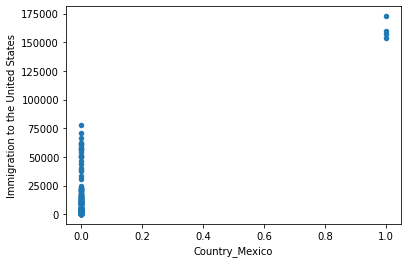

In [9]:
# Looks like Country_Mexico and Population Estimate are two features that have the strongest correlation.
# However, this doesn't mean that we can use Linear Regression to produce a model right a way.
# Let's graph to see if this model is linear, and therefore to see if Linear Regression is the right metric.

df.plot(kind='scatter', x='Country_Mexico', y='Immigration to the United States')

<AxesSubplot:xlabel='Population Estimate', ylabel='Immigration to the United States'>

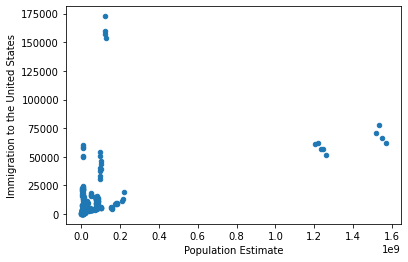

In [10]:
# Well, doesn't look like a linear relationship. What about Population Estimate?
df.plot(kind='scatter', x='Population Estimate', y='Immigration to the United States')

In [25]:
# Definitely not linear. So, we should, at this point, thinking of alternative version of Linear Regression like LASSO or Ridge.
# Though, let's test out LinearRegression as our base model.

reg = LinearRegression()
tx = pd.read_csv('train_x_region.csv')
tx.drop(['Region'], axis=1, inplace=True)
tx.drop(['Country'], axis=1, inplace=True)

ty = pd.read_csv('train_y.csv')
tf = pd.read_csv('test_x_region.csv')
tf.drop(['Region'], axis=1, inplace=True)
tf.drop(['Country'], axis=1, inplace=True)

reg.fit(tx, ty)

LinearRegression()

In [29]:
hyp = reg.predict(tf)
hyp

array([[11605.73532075],
       [19054.10021425],
       [13710.50451466],
       [12264.37190479],
       [ 1444.76329281],
       [ 8679.69366886],
       [  402.96253811],
       [ 8736.39993575],
       [13476.89094942],
       [ 4793.86290417],
       [10358.1299075 ],
       [ 5182.5796331 ],
       [ 1488.20841548],
       [17605.2543869 ],
       [15436.79578836],
       [11899.00271282],
       [ 5071.48824421],
       [15099.52818359],
       [ 2439.18173142],
       [ 2248.40172065],
       [ 1676.6308538 ],
       [12994.61690828],
       [-1265.63805857],
       [ -592.41228941],
       [18880.78418723],
       [ 6790.77224977],
       [19606.25660623],
       [ 4637.92210999],
       [23476.81903291],
       [ 8253.40375695],
       [13489.48139142],
       [ 1041.70286508],
       [ 7553.20968578],
       [ 5780.4312343 ],
       [ 8336.91787835],
       [12772.97322241],
       [ 5135.39088223],
       [ 6160.39649821],
       [15516.81380828],
       [13281.5687785 ],
